In [21]:
import pickle
import warnings
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [22]:
# 数据配置
DATA_TYPE = 'male_high_rank'
ALIGNMENT_POINT = 'i_dm'
BRAIN_REGION = 'mPFC'

# 时间索引
DECISION_MAKING_INDEX = 100
IN_INDEX = 150
OUT_INDEX = 450
NUM_TIMEPOINTS = 600
NUM_TIMEPOINTS_twotrial = 2400

# 跨trial时间索引
DM1_INDEX = 100 # 100
IN1_INDEX = DM1_INDEX + 1 * 50 # 150
OUT1_INDEX = IN1_INDEX + 6 * 50 # 450
T_END1_INDEX = OUT1_INDEX + (3+13) * 50 # 1250
DM2_INDEX = T_END1_INDEX + (11+2) * 50 # 1900
IN2_INDEX = DM2_INDEX + 1 * 50 # 1950
OUT2_INDEX = IN2_INDEX + 6 * 50 # 2250

# 选择转换类型
TRANS_TYPES = ['w-w', 'w-g', 'g-w', 'g-g']

# 颜色配置
CHOICE_TRANSITION_COLORS = {
    'w-w': 'red',
    'g-w': 'purple',
    'w-g': 'dodgerblue',
    'g-g': 'blue'
}

SINGLE_COLORS = {
    'w': 'red',
    'g': 'blue',
}

# 时间窗口
TIME_WINDOWS = {
    "Before turn": (0, DECISION_MAKING_INDEX),
    "In-to-out": (IN_INDEX, OUT_INDEX),
    "After Out": (OUT_INDEX, NUM_TIMEPOINTS)
}

In [23]:
def set_layout(ax):
    """统一设置图形样式"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='both', which='major', length=6, width=2, direction='out',
                  color='black', labelsize=10, bottom=True, left=True,
                  top=False, right=False)
    ax.grid(False)


def add_event_markers(ax, shift=-150):
    """添加事件标记线"""
    ax.axvline(x=DECISION_MAKING_INDEX + shift, color='k', linestyle='--', linewidth=2)
    ax.axvline(x=IN_INDEX + shift, color='k', linestyle='--', linewidth=2)
    ax.axvline(x=OUT_INDEX + shift, color='k', linestyle='--', linewidth=2)

def add_cross_trial_markers(ax, shift=-150):
    """添加跨trial事件标记"""
    ax.axvline(x=DM1_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=IN1_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=OUT1_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=T_END1_INDEX + shift, color='black', linestyle='-', linewidth=2, alpha=0.8)
    ax.axvline(x=DM2_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=IN2_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(x=OUT2_INDEX + shift, color='black', linestyle='--', linewidth=2, alpha=0.8)

def add_day_sep(ax, add_baseline=False, trial_type='all'):

    if trial_type == 'all':
        lines = [0, 20, 50, 80, 110, 140]
    elif trial_type == 'w':
        lines = [0, 10, 30, 50, 70, 92]
    elif trial_type == 'g':
        lines = [0, 12, 27, 42, 55, 68]

    if add_baseline:
        ax.axvline(x=lines[1], color='black', linestyle='--', linewidth=2, alpha=0.8)
        shift = 0
    else:
        shift = -lines[1]

    for l in lines[1:]:
        ax.axvline(x=l+shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
        ax.axvline(x=l+shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
        ax.axvline(x=l+shift, color='black', linestyle='--', linewidth=2, alpha=0.8)
        ax.axvline(x=l+shift, color='black', linestyle='--', linewidth=2, alpha=0.8)

def significance_label(p):
    """生成显著性标签"""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return str(p)

In [24]:
def load_data():
    file_path_sep_trial = f'./data/reorganized_dataset/{DATA_TYPE}/warped_DA_datasets_{ALIGNMENT_POINT}.pkl'
    file_path_across_trial = f'./data/reorganized_dataset/{DATA_TYPE}/warped_DA_datasets_cross_trial.pkl'
    file_path_matrix = f'./data/reorganized_dataset/{DATA_TYPE}/{BRAIN_REGION}_matrices_{ALIGNMENT_POINT}.pkl'

    with open(file_path_sep_trial, 'rb') as file:
        DA = pickle.load(file)
    with open(file_path_across_trial, 'rb') as file:
        DA_across_trial = pickle.load(file)
    with open(file_path_matrix, 'rb') as f:
        DA_matrix = pickle.load(f)

    return DA, DA_across_trial, DA_matrix


def preprocess_data(DA, DA_across_trial):
    """数据预处理和特征工程"""
    # 过滤脑区
    DA = DA[DA['brain_region'] == BRAIN_REGION]
    DA_across_trial = DA_across_trial[DA_across_trial['brain_region'] == BRAIN_REGION]

    # 创建选择转换特征
    DA['prev_curr_choice'] = DA['prev_choice'] + '-' + DA['current_choice']
    DA['curr_next_choice'] = DA['current_choice'] + '-' + DA['next_choice']
    DA_across_trial['trial1_trial2_choice'] = (
            DA_across_trial['current_choice_1'] + '-' + DA_across_trial['current_choice_2']
    )

    # 转换单位
    DA['warped_signal'] = DA['warped_signal']*100
    DA_across_trial['cross_trial_warped_signal'] = DA_across_trial['cross_trial_warped_signal'] * 100

    # 分割数据集
    DA_wo_baseline = DA[DA['phase_id'] != 'baseline']
    DA_only_baseline = DA[DA['phase_id'] == 'baseline']
    DA_across_trial_wo_baseline = DA_across_trial[DA_across_trial['phase_id'] != 'baseline']
    DA_across_trial_only_baseline = DA_across_trial[DA_across_trial['phase_id'] == 'baseline']

    return DA, DA_wo_baseline, DA_only_baseline, DA_across_trial_wo_baseline, DA_across_trial_only_baseline


# 加载和预处理数据
DA, DA_across_trial, DA_matrix = load_data()
DA, DA_wo_baseline, DA_only_baseline, DA_across_trial_wo_baseline, DA_across_trial_only_baseline = preprocess_data(DA, DA_across_trial)

print(f"数据加载完成:")
print(f"  - 基线期trials: {len(DA_only_baseline)}")
print(f"  - 非基线期trials: {len(DA_wo_baseline)}")
print(f"  - 跨trial数据: {len(DA_across_trial_wo_baseline)}")


数据加载完成:
  - 基线期trials: 115
  - 非基线期trials: 674
  - 跨trial数据: 659


In [25]:
DA.columns

Index(['mouse_id', 'phase_id', 'trial_id', 'warped_signal',
       'warped_signal_normed', 'warped_out_to_next_in_signal',
       'warped_out_to_next_in_signal_normed',
       'warped_prev_out_to_curr_in_signal',
       'warped_prev_out_to_curr_in_signal_normed', 't_start', 't_end',
       'dm_time', 'i_time', 'o_time', 'dm_time_rel_idx', 'i_time_rel_idx',
       'o_time_rel_idx', 'original_df_f', 'brain_region', 'current_choice',
       'next_choice', 'prev_choice', 'prev_curr_choice', 'curr_next_choice'],
      dtype='object')

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def lagged_regression_with_current_next(df, n_lag=5):

    # 排序，保证 trial 顺序正确
    df = df.sort_values(["mouse_id", "phase_id", "trial_id"]).copy()

    # ---- 1. 创建滞后项（过去 trial 的选择） ----
    for k in range(1, n_lag+1):
        df[f"choice_lag_{k}"] = df.groupby(["mouse_id", "phase_id"])["current_choice"].shift(k)

    # ---- 2. 创建当前 choice（已存在），创建下一 trial choice ----
    df["choice_next"] = df.groupby(["mouse_id", "phase_id"])["current_choice"].shift(-1)

    # 删除因为 shift 造成的 NA
    df = df.dropna(subset=[f"choice_lag_{k}" for k in range(1, n_lag+1)] + ["choice_next"])

    # ---- 3. 展开 warped_signal： N_trial × 600 ----
    warped_mat = np.vstack(df["warped_signal"].values)   # (N, 600)

    # ---- 4. 构建设计矩阵 X ----
    regressors = ["current_choice", "choice_next"] + \
                 [f"choice_lag_{k}" for k in range(1, n_lag+1)]

    X = df[regressors].values

    # ---- 5. 对 600 个时间点分别做线性回归 ----
    n_time = warped_mat.shape[1]
    n_reg  = len(regressors)

    coef_matrix = np.zeros((n_time, n_reg))

    for t in range(n_time):
        y = warped_mat[:, t]

        model = LinearRegression().fit(X, y)
        coef_matrix[t, :] = model.coef_

    return coef_matrix, regressors
mapping = {'g': 0, 'w': 1}
DA['current_choice'] = DA['current_choice'].map(mapping)
DA_only_baseline['current_choice'] = DA_only_baseline['current_choice'].map(mapping)
DA_wo_baseline['current_choice'] = DA_wo_baseline['current_choice'].map(mapping)
coef_matrix, reg_names = lagged_regression_with_current_next(DA_wo_baseline, n_lag=5)


In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def lagged_regression_stats(df, n_lag=5):
    # 排序
    df = df.sort_values(["mouse_id", "phase_id", "trial_id"]).copy()

    # 构建滞后项
    for k in range(1, n_lag+1):
        df[f"choice_lag_{k}"] = df.groupby(["mouse_id", "phase_id"])["current_choice"].shift(k)

    # 下一 trial 的 choice
    df["choice_next"] = df.groupby(["mouse_id", "phase_id"])["current_choice"].shift(-1)

    # 删除 NA
    df = df.dropna(subset=[f"choice_lag_{k}" for k in range(1, n_lag+1)] + ["choice_next"])

    # 展开 warped_signal
    warped_mat = np.vstack(df["warped_signal"].values)   # (N, 600)

    # 原始顺序: current, next, lag1...
    regressors = ["current_choice", "choice_next"] + [f"choice_lag_{k}" for k in range(1, n_lag+1)]
    X = df[regressors].values
    X = sm.add_constant(X)   # 加截距项

    n_time = warped_mat.shape[1]
    n_reg  = X.shape[1]      # const + regressors

    coef_matrix = np.zeros((n_time, n_reg))
    pval_matrix = np.zeros((n_time, n_reg))

    for t in range(n_time):
        y = warped_mat[:, t]
        model = sm.OLS(y, X).fit()
        coef_matrix[t, :] = model.params
        pval_matrix[t, :] = model.pvalues

    # 调整列顺序: const, next, current, lag1, lag2...
    col_order = ["const", "choice_next", "current_choice"] + [f"choice_lag_{k}" for k in range(1, n_lag+1)]
    col_indices = [regressors.index(name) + 1 if name != "const" else 0 for name in col_order]  # +1 因为加了常数列
    coef_matrix = coef_matrix[:, col_indices]
    pval_matrix = pval_matrix[:, col_indices]

    return coef_matrix, pval_matrix, col_order


In [28]:
coef_matrix, pval_matrix, reg_names = lagged_regression_stats(DA_wo_baseline, n_lag=5)


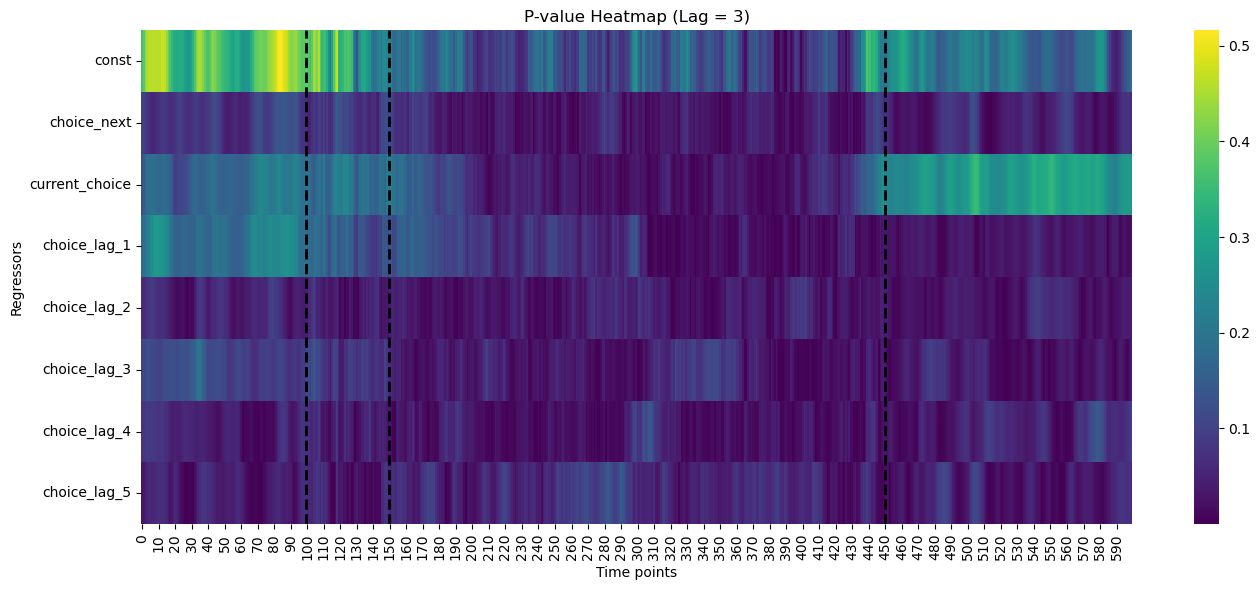

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pval_matrix_sns(pval_matrix, reg_names, lag_id=None):
    """
    pval_matrix: shape (n_time, n_regressors)
    reg_names: list of regressor names
    lag_id: optional, 用于标题
    """
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        pval_matrix.T,     # 使regressors在行方向
        cmap="viridis",     # 红色系，p 越小越红
        # vmin=0, vmax=0.05,  # 常用显著性范围
        cbar=True
    )

    plt.yticks(
        ticks = np.arange(len(reg_names)) + 0.5,
        labels = reg_names,
        rotation = 0
    )

    plt.xlabel("Time points")
    plt.ylabel("Regressors")

    if lag_id is None:
        plt.title("P-value Heatmap")
    else:
        plt.title(f"P-value Heatmap (Lag = {lag_id})")
    add_event_markers(plt.gca(), shift=0)

    plt.tight_layout()
    plt.show()
plot_pval_matrix_sns(np.abs(coef_matrix), reg_names, lag_id=3)


In [30]:
coef_matrix.shape

(600, 8)

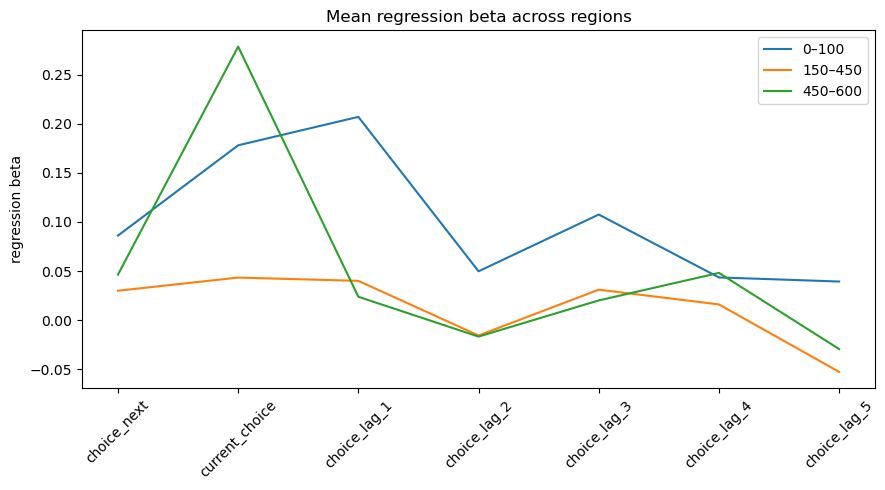

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# coef_matrix 已加载
# 1. 转置
coef_T = coef_matrix.T    # shape: (8, 600)

# 2. 删掉第一行
coef_T = coef_T[1:, :]    # shape: (7, 600)

# 3. 设定横轴标签（与行数一致）
x_labels = [
    "choice_next",
    "current_choice",
    "choice_lag_1",
    "choice_lag_2",
    "choice_lag_3",
    "choice_lag_4",
    "choice_lag_5",
]

# 如果你希望第一个标签是 choice_next，可改成：
# x_labels = ["choice_next", "current_choice", "choice_lag_1", ...,]

# 4. 定义三个区域
regions = {
    "0–100":   (0, 100),
    "150–450": (150, 450),
    "450–600": (450, 600)
}

# 5. 对每个区域计算平均值
mean_values = {}
for name, (start, end) in regions.items():
    region_slice = coef_T[:, start:end]           # shape: (7, 区域长度)
    mean_values[name] = region_slice.mean(axis=1) # 每一行一个均值

# 6. 绘图
plt.figure(figsize=(9, 5))

x = np.arange(coef_T.shape[0])   # 0~6

for name, mv in mean_values.items():
    plt.plot(x, mv, label=name)

plt.xticks(x, x_labels, rotation=45)
plt.ylabel("regression beta")
plt.title("Mean regression beta across regions")
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# -------------------------
# 1. 回归函数：窗口平均 + OLS p 值 + SEM
# -------------------------
def window_mean_regression_with_SEM(df, n_lag=5,
                                    windows={
                                        "0–100":   (0, 100),
                                        "150–450": (150, 450),
                                        "450–600": (450, 600)
                                    }):
    df = df.sort_values(["mouse_id", "phase_id", "trial_id"]).copy()

    # 构造滞后变量
    for k in range(1, n_lag+1):
        df[f"choice_lag_{k}"] = df.groupby(["mouse_id", "phase_id"])["current_choice"].shift(k)

    df["current_choice"] = df["current_choice"]

    df = df.dropna(subset=["current_choice"] + [f"choice_lag_{k}" for k in range(1, n_lag+1)])

    signal = np.vstack(df["warped_signal"].values)  # (n_trials, 600)
    regressors = ["current_choice"] + [f"choice_lag_{k}" for k in range(1, n_lag+1)]
    X = df[regressors].values
    X_const = sm.add_constant(X)

    betas = []
    SEMs  = []
    pvals = []

    for name, (start, end) in windows.items():
        y = signal[:, start:end].mean(axis=1)
        model = sm.OLS(y, X_const).fit()
        betas.append(model.params[1:])      # 去掉截距
        SEMs.append(model.bse[1:])          # 标准误 = SEM
        pvals.append(model.pvalues[1:])     # p值

    return np.array(betas), np.array(SEMs), np.array(pvals), regressors, list(windows.keys())


In [78]:
betas, SEMs, pvals, x_labels, region_names = window_mean_regression_with_SEM(DA_wo_baseline, n_lag=4)
betas.shape

(3, 5)

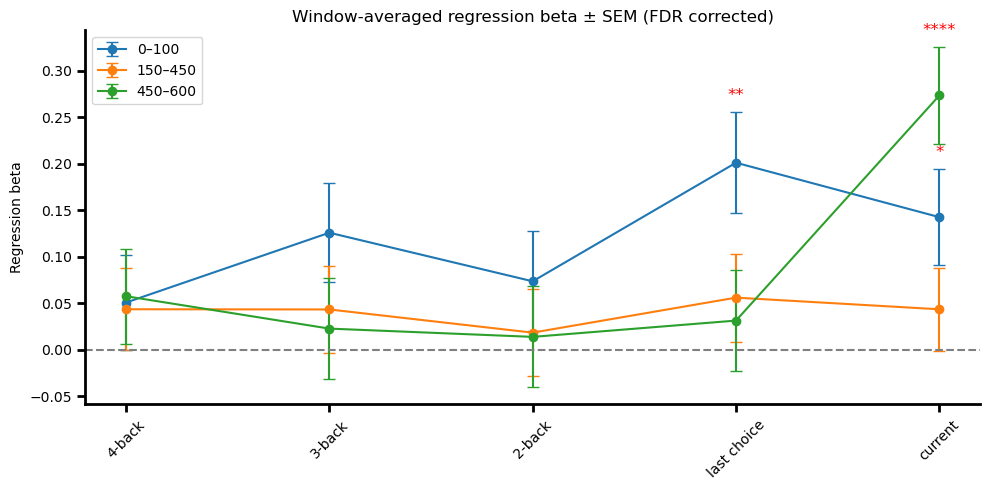

In [79]:
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import numpy as np

# -------------------------
# 横轴 label（左到右：历史 → 当前）
# -------------------------
new_labels = ["4-back", "3-back", "2-back", "last choice", "current"]

# 数据重排
reorder_idx = [4,3,2,1,0]  # lag_5→lag_4→...→current
betas = betas[:, reorder_idx]
SEMs  = SEMs[:, reorder_idx]
pvals = pvals[:, reorder_idx]

# -------------------------
# FDR 校正
# -------------------------
pvals_flat = pvals.flatten()
reject, pvals_corrected, _, _ = multipletests(pvals_flat, alpha=0.05, method='fdr_bh')
pvals_corrected = pvals_corrected.reshape(pvals.shape)

# -------------------------
# 绘图
# -------------------------
fig, ax = plt.subplots(figsize=(10,5))
x = np.arange(len(new_labels))

for i, region_name in enumerate(region_names):
    ax.errorbar(x, betas[i], yerr=SEMs[i], fmt='-o', capsize=4, label=region_name)

# 根据 FDR 校正 p 值分级标注显著性
for i in range(len(region_names)):
    for j in range(len(new_labels)):
        p = pvals_corrected[i, j]
        if p<0.0001:
            star = "****"
        elif p < 0.001:
            star = "***"
        elif p < 0.01:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = ""
        if star:
            ax.text(j, betas[i,j] + SEMs[i,j] + 0.01, star, ha='center', va='bottom', fontsize=12, color='red')

ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks(x)
ax.set_xticklabels(new_labels, rotation=45)
ax.set_ylabel("Regression beta")
ax.set_title("Window-averaged regression beta ± SEM (FDR corrected)")
ax.legend()
set_layout(ax)
fig.tight_layout()
plt.show()


In [81]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# -------------------------
# 回归函数 + 计算 N
# -------------------------
def window_mean_regression_with_SEM_and_N(df, n_lag=5,
                                          windows={
                                              "0–100":   (0, 100),
                                              "150–450": (150, 450),
                                              "450–600": (450, 600)
                                          }):
    df = df.sort_values(["mouse_id", "phase_id", "trial_id"]).copy()

    # 构造滞后变量
    for k in range(1, n_lag+1):
        df[f"choice_lag_{k}"] = df.groupby(["mouse_id", "phase_id"])["current_choice"].shift(k)

    df["current_choice"] = df["current_choice"]

    df = df.dropna(subset=["current_choice"] + [f"choice_lag_{k}" for k in range(1, n_lag+1)])

    signal = np.vstack(df["warped_signal"].values)  # (n_trials, 600)
    regressors = ["current_choice"] + [f"choice_lag_{k}" for k in range(1, n_lag+1)]
    X = df[regressors].values
    X_const = sm.add_constant(X)

    betas = []
    SEMs  = []
    pvals = []
    Ns    = []

    for name, (start, end) in windows.items():
        y = signal[:, start:end].mean(axis=1)
        model = sm.OLS(y, X_const).fit()
        betas.append(model.params[1:])      # 去掉截距
        SEMs.append(model.bse[1:])          # 标准误 = SEM
        pvals.append(model.pvalues[1:])     # p值
        Ns.append(len(y))                    # 每个窗口的 N

    return np.array(betas), np.array(SEMs), np.array(pvals), regressors, list(windows.keys()), np.array(Ns)

# -------------------------
# 假设 df 已准备好
# -------------------------
betas, SEMs, pvals, regressors, window_names, Ns = window_mean_regression_with_SEM_and_N(DA_wo_baseline, n_lag=4)

# -------------------------
# 横轴顺序：历史 → 当前
# -------------------------
lag_labels = ["4-back", "3-back", "2-back", "last choice", "current"]
reorder_idx = [4,3,2,1,0]
betas = betas[:, reorder_idx]
SEMs  = SEMs[:, reorder_idx]

# N 值每个窗口对所有滞后相同，可扩展成矩阵
Ns_matrix = np.tile(Ns[:, None], (1, len(lag_labels)))

# -------------------------
# 构建 CSV
# -------------------------
csv_data = {"Lag": lag_labels}

for i, window_name in enumerate(window_names):
    csv_data[f"{window_name}_Mean"] = betas[i]
    csv_data[f"{window_name}_SEM"]  = SEMs[i]
    csv_data[f"{window_name}_N"]    = Ns_matrix[i]

# 转成 DataFrame
df_csv = pd.DataFrame(csv_data)

# 保存 CSV
df_csv.to_csv("regression_summary.csv", index=False)
print("CSV saved as regression_summary.csv")


CSV saved as regression_summary.csv
